# Nerual Network from scratch

Author: Joaquín Palacios, october 2025

This projects aims to produce a neural network that can serve as a classificator for benchmark data problems. The main objective is to dive into the realm of neural networks in it's simplest form: a sequential neural network of dense layers for classifying the MNIST digits dataset. 

The spirit of the implementation rather than having a rigid architecture, has a more flexible structure in wich one can choose how many layers and its length (amount of artifitial neurons) and it's activation function. 

This way the math behind the neural network training gets a little more tricky since it has to adapt to many amount of layers, but it remains a doable challenge. 

In [2]:
import numpy as np
import sys 
import pandas as pd
np.random.seed(43)

In [3]:
data = pd.read_csv('digit-recognizer/train.csv')
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.

In [4]:
def onehot(y, n):
    onehot = np.zeros((n, y.shape[0]))
    for i, val in enumerate(y.astype(int)):
        onehot[val, i] = 1.
    return onehot.T
Y_train = onehot(Y_train, 10)
Y_dev = onehot(Y_dev, 10)

In [5]:
def sigmoid(x):
	return(1/(1 + np.exp(-x)))
    
def sigmoid_prime(x):
    return x * (1. - x)
    
def relu(x):
    return np.maximum(0,x)
    
def relu_prime(x):
    return 1. * (x > 0)
    
def softmax(x):
    x_shift = x - np.max(x, axis=0, keepdims=True)
    exps = np.exp(x_shift)
    sum_exps = np.sum(exps, axis=0, keepdims=True)
    return exps / (sum_exps +1e-9)

## Classes

We implemented two classes: the Dense Layer class that works as a layer object that holds its own weights and biases and the Model class that aggregates layers, trains the model performing the backpropagation trough a number of epochs and iterations over batches. 

A Model gets added layers to implement the architecture of the netwrok and holds a history for the training. It also can predict for a given value on the shape of its input.

In [7]:
class DenseLayer:

    derivatives = {'sigmoid':sigmoid_prime,'relu':relu_prime}
    
    def __init__(self, name, activation = relu, length = 50, input_shape = None):
        self.name = name
        self.activation = activation
        self.length = length
        self.W = []
        self.b = np.random.randn(self.length)
        self.b = self.b.reshape(self.length,1)
        if input_shape:
            self.input_shape=input_shape
            self.W = np.random.randn(self.length, self.input_shape[0]) * np.sqrt(2.0 / self.input_shape[0])

    def set_connection_before(self,previous_layer):
        assert previous_layer != self, "Cannot connect the same layer with itself"
        self.input_shape=(previous_layer.length,)
        self.W = np.random.randn(self.length, self.input_shape[0]) * np.sqrt(2.0 / self.input_shape[0])

    def feed_forward(self, x):
        assert x.shape[0] == self.input_shape[0], f"Shape of input not valid, must be {self.input_shape} and it's {x.shape}"
        z = self.W.dot(x)
        z = np.add(z, self.b)
        a = self.activation(z)
        return a
        
    def get_derivative(self):
        return self.derivatives[self.activation.__name__]

    def get_weights(self):
        return self.W
        
    def set_weights(self, W):
        self.W = W

    def get_biases(self):
        return self.b

    def set_biases(self, b):
        assert self.b.shape == b.shape, f"Shape of new weights {b.shape} is not correct, must be {self.b.shape}"
        self.b = b


In [8]:
class Model:
    def __init__(self, eta=0.05,l2=0.01):
        self.layers = []
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        self.eta = eta
        self.l2 = l2
        self.random = np.random.RandomState(43)
    
    def add(self, layer):
        if self.layers:
            layer.set_connection_before(self.layers[-1])
        self.layers.append(layer)

    def _forward_prop(self, X):
        a = []
        a.append(X)
        a.append(self.layers[0].feed_forward(X))
        for layer in self.layers[1:]:
            a.append(layer.feed_forward(a[-1]))
        return a

    def _update_weights(self, layer, delta_w, delta_b):
        new_weights = layer.get_weights() - self.eta * delta_w
        layer.set_weights(new_weights)
        new_biases = layer.get_biases() - self.eta * delta_b
        layer.set_biases(new_biases)
    
    def _backprop(self, a, y):
        m = len(y)
        last_del = len(self.layers)-1
        last_a = len(a)-1
        delta = list(range(len(self.layers)))
        delta_w = list(range(len(self.layers)))
        delta_b = list(range(len(self.layers)))
        delta[last_del] = a[last_a] - y.T
        for i in range(last_del,0,-1):
            delta_w[i] = delta[i].dot(a[i].T) / m + (self.l2 / m) * self.layers[i].get_weights()
            delta_b[i] = np.sum(delta[i],axis=1) / m
            delta_b[i] = delta_b[i].reshape(-1, 1)
            self._update_weights(self.layers[i],delta_w[i],delta_b[i])
            derivative = self.layers[i-1].get_derivative()
            delta[i-1] = np.dot(self.layers[i].get_weights().T,delta[i]) * derivative(a[i])
        delta_w[0] = delta[0].dot(a[0].T) / m + (self.l2 / m) * self.layers[0].get_weights()
        delta_b[0] = np.sum(delta[0],axis=1) / m    
        delta_b[0] = delta_b[0].reshape(-1, 1)
        self._update_weights(self.layers[0],delta_w[0],delta_b[0])   
        
    def fit(self, X_train, y_train, X_valid, y_valid, epochs=20, batch_size=50):
        n_samples = X_train.shape[1]
        n_valid = X_valid.shape[1]
        epoch_strlen = len(str(epochs)) 
        for i in range(epochs):
            indices = np.arange(n_samples)
            self.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0] - batch_size +1, batch_size):
                batch_idx = indices[start_idx:start_idx + batch_size]
                x0 = X_train[:,batch_idx]
                y0 = y_train[batch_idx]
                ## This way for each image the model has a column to send as input and every operation is seen as a column
                ##forward propagation
                a = self._forward_prop(x0)
                ##back propagation
                self._backprop(a,y0)
            
            ##evaluating after one epoch of training
            a = self._output(X_train)
            cost = self._compute_error(y=y_train.T,output=a)

            y_train_pred = np.argmax(self.predict(X_train),axis=0)
            y_train_labels = np.argmax(y_train,axis=1)
            y_valid_pred = np.argmax(self.predict(X_valid),axis=0)
            y_valid_labels = np.argmax(y_valid,axis=1)
            train_acc = self._get_accuracy(y_train_labels,y_train_pred, n_samples)
            valid_acc = self._get_accuracy(y_valid_labels,y_valid_pred, n_valid)
        
            print(f"{i+1}/{epochs} | Cost: {cost:.2f} | Train/Valid Acc.: {(train_acc*100):.2f}/{(valid_acc*100):.2f}")
            #sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        return self

    def _get_accuracy(self, true_labels, predicted_labels, n):
        return np.sum(true_labels==predicted_labels) / n
        
    def _compute_error(self,y,output):
        cost = -np.sum(y * np.log(output + 1e-9))
        return cost

    def _output(self, X):
        a = []
        a.append(self.layers[0].feed_forward(X))
        for i in range(1,len(self.layers)):
            a.append(self.layers[i].feed_forward(a[-1]))
        return a[-1]
        
    def predict(self, X):
        return self._output(X)

## Training and testing

Here we train and test our home made network. We trained it over a desktop PC without a GPU, since the aim of the project is to understand the underlying works of neural networks, this does not have permforming improvements for the training.

In [10]:
nn = Model(eta=0.01)
nn.add(DenseLayer("hidden1",activation = relu, input_shape=(784,),length=50))
nn.add(DenseLayer("hidden2",activation = relu,length=10))
nn.add(DenseLayer("output",activation = softmax, length=10))

In [11]:
nn.fit(X_train, Y_train, X_dev, Y_dev)

1/20 | Cost: 41251.96 | Train/Valid Acc.: 72.39/73.00
2/20 | Cost: 24774.35 | Train/Valid Acc.: 82.40/82.60
3/20 | Cost: 19828.54 | Train/Valid Acc.: 85.92/85.80
4/20 | Cost: 16818.01 | Train/Valid Acc.: 88.34/88.00
5/20 | Cost: 14638.54 | Train/Valid Acc.: 89.91/89.90
6/20 | Cost: 13250.78 | Train/Valid Acc.: 90.60/91.00
7/20 | Cost: 11914.39 | Train/Valid Acc.: 91.73/92.60
8/20 | Cost: 11062.99 | Train/Valid Acc.: 92.35/93.20
9/20 | Cost: 10324.74 | Train/Valid Acc.: 92.76/93.50
10/20 | Cost: 9765.08 | Train/Valid Acc.: 93.30/93.60
11/20 | Cost: 9235.10 | Train/Valid Acc.: 93.61/94.00
12/20 | Cost: 8884.29 | Train/Valid Acc.: 93.90/93.20
13/20 | Cost: 8416.13 | Train/Valid Acc.: 94.13/94.20
14/20 | Cost: 8109.48 | Train/Valid Acc.: 94.41/93.70
15/20 | Cost: 7682.76 | Train/Valid Acc.: 94.63/94.50
16/20 | Cost: 7387.97 | Train/Valid Acc.: 94.78/94.80
17/20 | Cost: 7237.97 | Train/Valid Acc.: 94.89/94.80
18/20 | Cost: 6871.89 | Train/Valid Acc.: 95.12/95.50
19/20 | Cost: 7055.42 | Trai

The end result is a 95.3 accuracy over the validation set, a good result as the network has a small size, the training does not have any performing improvements.

In [13]:
from matplotlib import pyplot as plt

def test_prediction(index):
    current_image = X_train[:, index, None]
    prediction = nn.predict(X_train[:, index].reshape((784,1)))
    label = Y_train[index]
    print("Prediction: ", np.argmax(prediction))
    print("Label: ", np.argmax(label))
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

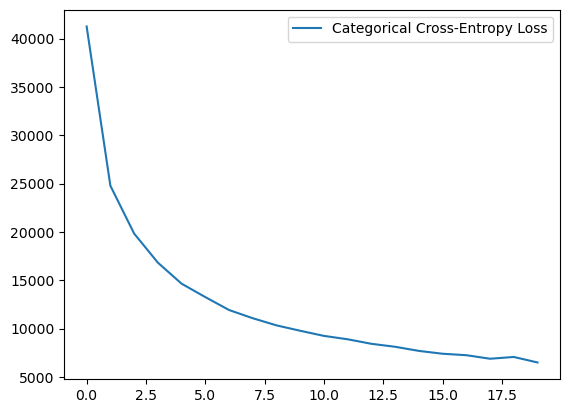

In [14]:
history = nn.eval_
plt.plot(history['cost'], label="Categorical Cross-Entropy Loss")
plt.legend()

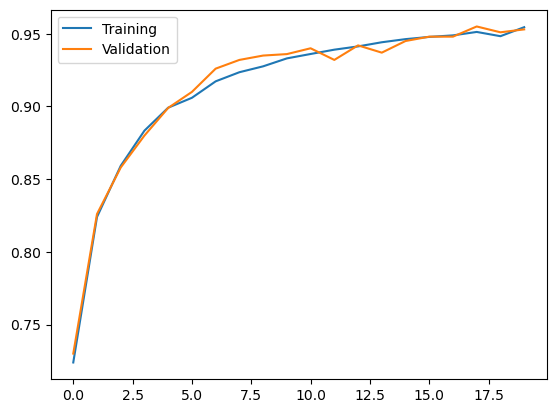

In [15]:
plt.plot(history['train_acc'],label="Training")
plt.plot(history['valid_acc'],label="Validation")
plt.legend()

As we see on the validation accuracy (the accuracy on predicting values the networks it was not trained on) follows closely the training accuracy, so we can see the model is not overfitting, one of the many problems one can find in implementing neural networks

Prediction:  9
Label:  9


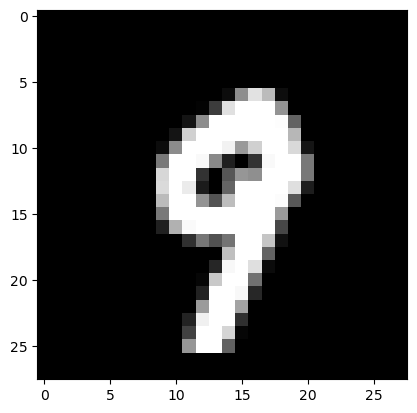

Prediction:  7
Label:  7


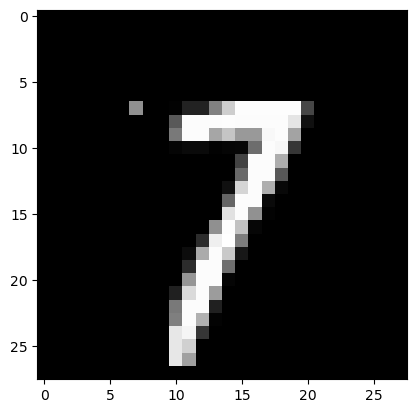

Prediction:  9
Label:  9


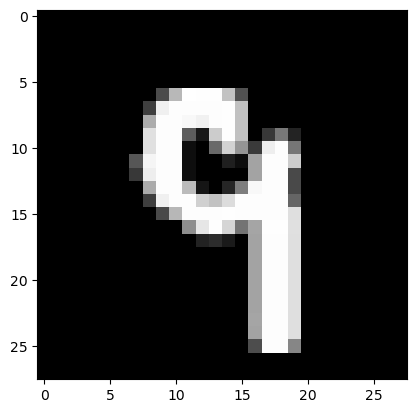

Prediction:  4
Label:  4


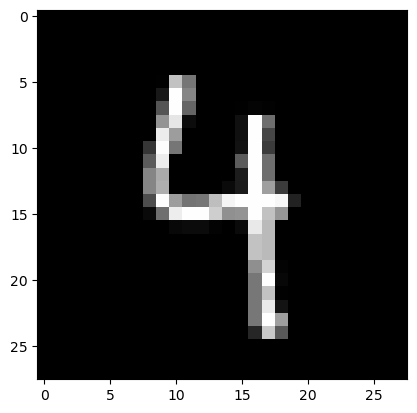

Prediction:  0
Label:  0


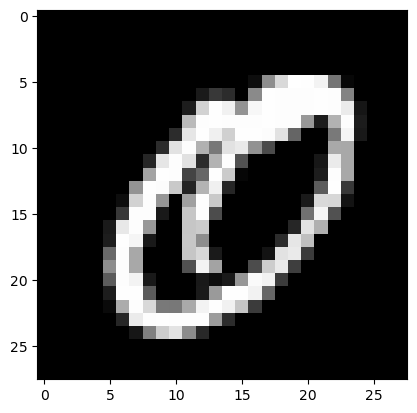

Prediction:  8
Label:  8


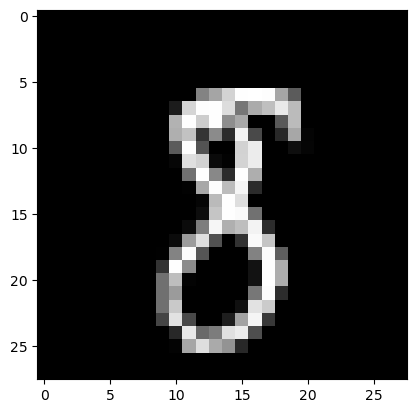

Prediction:  5
Label:  5


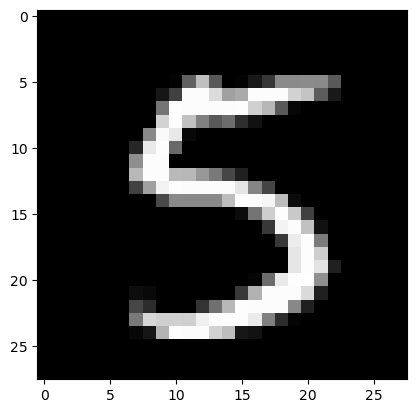

Prediction:  0
Label:  0


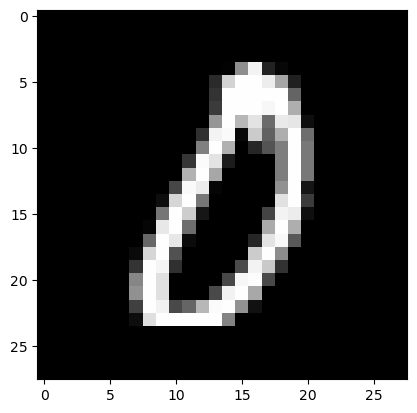

Prediction:  6
Label:  6


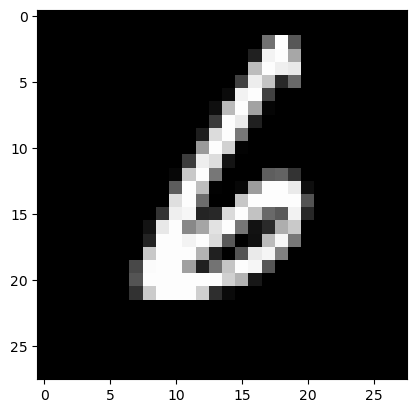

Prediction:  0
Label:  0


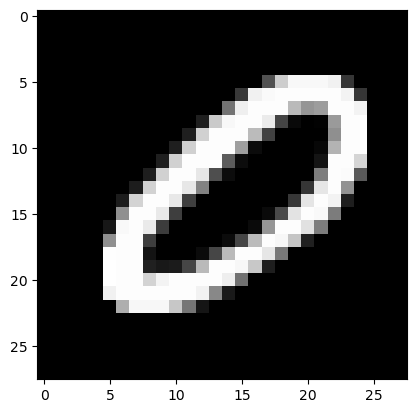

In [17]:
for i in range(10):
    test_prediction(i)

## Conclusion

We implemented a little neural network framework to create models and make prediction on categorical datasets. We saw that it's accuracy nears those of current state of the start frameworks used in the industry, although it was not the scope of the project mirror the training performance of those.